# **Credit Card Fraud Detection** - Anomaly Detection

This notebook is part of the **ml-unsupervised** repo.  
We will use **unsupervised learning (anomaly detection)** techniques to detect fraudulent transactions in a credit card dataset.  

Fraud detection is a classic real-world use case for anomaly detection, because fraudulent transactions are very rare compared to normal transactions.  

📌 **Notebook roadmap**:  
1. Setup & Dataset  
2. Data Exploration (EDA)  
3. Preprocessing  
4. Anomaly Detection Models (Gaussian, Isolation Forest)  
5. Evaluation & Results  
6. Insights & Conclusion


### Setup & Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# Make plots look nicer
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)

# Ensure reproducibility
RANDOM_STATE = 42

### Load Dataset

In [2]:
data_path = "creditcard.csv"
df = pd.read_csv(data_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Quick Info & Summary

In [3]:
print("Dataset shape:", df.shape)
df.info()

df.describe().T.head(10)


Dataset shape: (284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-n

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


- The dataset contains ~285,000 transactions.  
- Features `V1–V28` are **PCA components** (original features hidden for privacy).  
- `Amount` = transaction amount, `Time` = seconds elapsed since first transaction.  
- `Class` = target label (0 = normal, 1 = fraud).  


### Missing Values Check

In [4]:
df.isnull().sum().any()


np.False_

### Class Distribution

Class
0    284315
1       492
Name: count, dtype: int64
Fraud cases (%): 0.1727


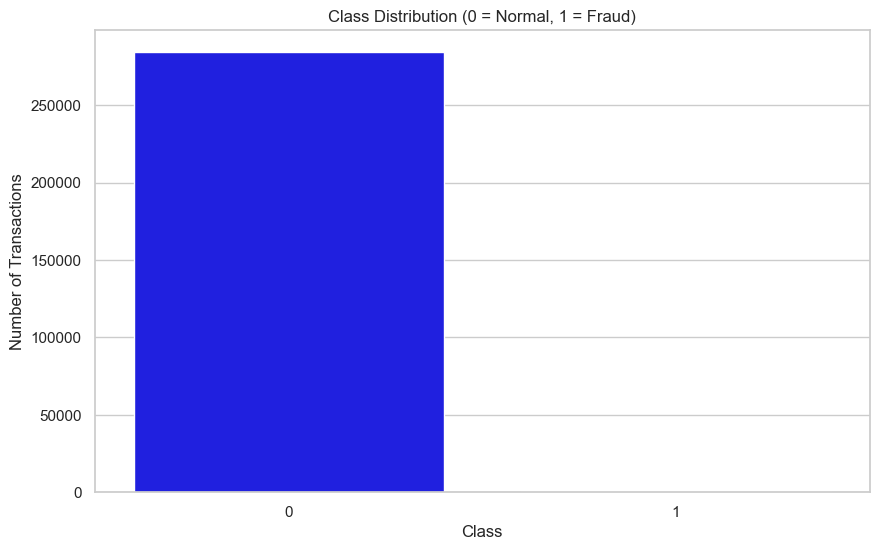

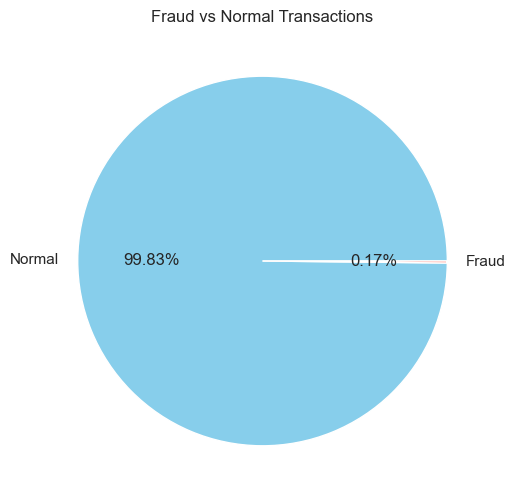

In [5]:
class_counts = df["Class"].value_counts()
print(class_counts)
print("Fraud cases (%):", round(class_counts[1] / len(df) * 100, 4))

# Bar plot
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette=["blue", "red"], legend=False)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.ylabel("Number of Transactions")
plt.xlabel("Class")
plt.show()

# Pie chart for visual clarity
plt.pie(class_counts, labels=["Normal", "Fraud"], autopct="%1.2f%%", colors=["skyblue", "salmon"])
plt.title("Fraud vs Normal Transactions")
plt.show()


The dataset is **extremely imbalanced**:  
- Normal transactions ≈ 99.83%  
- Fraudulent transactions ≈ 0.17%  

This imbalance is why **anomaly detection** is a suitable method.


### Transaction Amount Distribution (Fraud vs Non-Fraud)

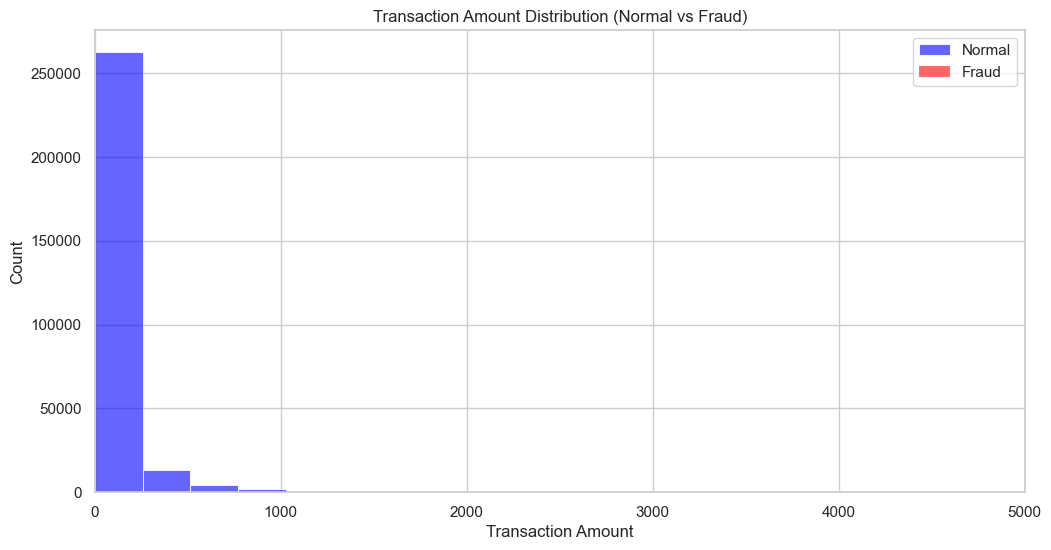

In [6]:
fraud = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

# Histogram
plt.figure(figsize=(12,6))
sns.histplot(normal["Amount"], bins=100, color="blue", label="Normal", alpha=0.6)
sns.histplot(fraud["Amount"], bins=100, color="red", label="Fraud", alpha=0.6)
plt.legend()
plt.title("Transaction Amount Distribution (Normal vs Fraud)")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.xlim(0, 5000) 
plt.show()

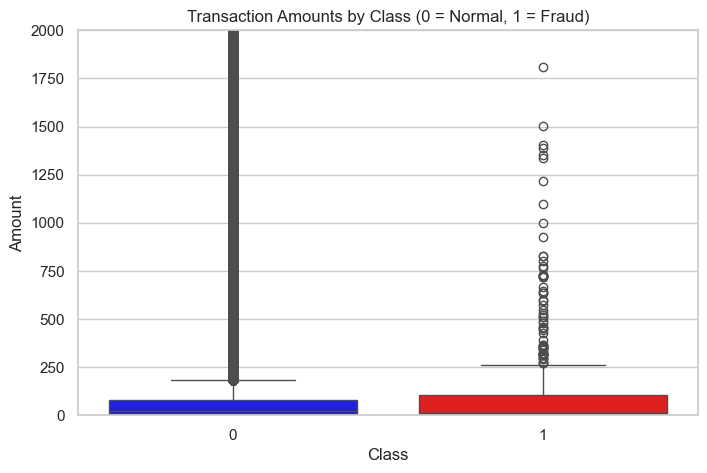

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Class", y="Amount", data=df, palette=["blue", "red"], hue="Class", legend=False)
plt.title("Transaction Amounts by Class (0 = Normal, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Amount")
plt.ylim(0, 2000) 
plt.show()


**Insights from Transaction Amounts**:
- Most transactions are **low-value (< $500)**.  
- Fraudulent transactions appear in a wide range, but there are noticeable spikes at specific amounts.  
- Boxplots show that while the median amounts are similar, **fraud cases include some outliers with very high values**.  

This suggests that transaction amount is a useful feature for anomaly detection.  


## Preprocessing

###  1. Scale Numerical Features

* Features `V1–V28` are already PCA-transformed → no need to scale.
* `Amount` and `Time` **are not scaled**, so we’ll normalize them.




In [8]:
df_prep = df.copy()


scaler = StandardScaler()
df_prep[["Amount", "Time"]] = scaler.fit_transform(df_prep[["Amount", "Time"]])
df_prep.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


###  2. Train-Test Split

We’ll split into **train + test** for later anomaly detection.

* Train on mostly **normal transactions** (unsupervised).
* Keep test with both fraud & normal for evaluation.

In [9]:
X = df_prep.drop("Class", axis=1)
y = df_prep["Class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Fraud ratio in test:", round(y_test.mean() * 100, 4), "%")

Train shape: (227845, 30)
Test shape: (56962, 30)
Fraud ratio in test: 0.172 %


###  3. Optional PCA Visualization (Good for EDA)

Even though features are already PCA-like, we can visualize **fraud vs normal** in 2D space.


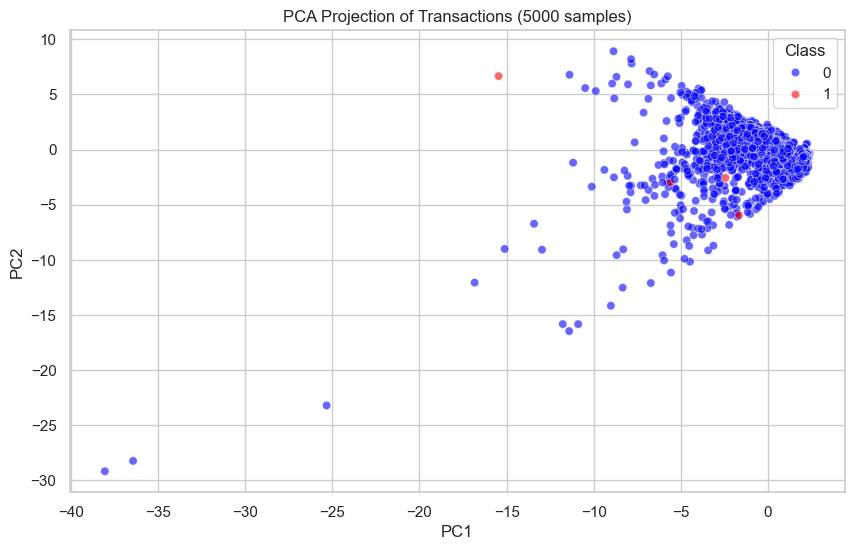

In [10]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

# Create DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Class"] = y.values

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df.sample(5000, random_state=RANDOM_STATE), 
                x="PC1", y="PC2", hue="Class", 
                palette={0:"blue", 1:"red"}, alpha=0.6)
plt.title("PCA Projection of Transactions (5000 samples)")
plt.show()

## **Gaussian Anomaly Detection**

In this step, we’ll implement **Gaussian Anomaly Detection** in two ways:

###  Intuition
1. Fit a **multivariate Gaussian distribution** on the features.  
2. Compute the **probability density** of each transaction under this distribution.  
3. Choose a **threshold (ε)**:  
   - If `p(x) < ε` → anomaly (fraud).  
   - Otherwise → normal.  

This gives us a probabilistic way of flagging rare, unusual transactions.

---

###  Method 1: Manual Implementation (Step-by-Step)
We’ll compute the Gaussian probability densities ourselves using the **mean** and **covariance matrix**.

In [11]:
def estimate_gaussian(X):
    mu = X.mean(axis=0).values
    sigma = np.cov(X.values, rowvar=False)
    return mu, sigma


def multivariate_gaussian(X, mu, sigma):
    p = multivariate_normal.pdf(X, mean=mu, cov=sigma)
    return p


def select_threshold(y_val, p_val):
    best_epsilon, best_f1 = 0, 0
    
    for eps in np.linspace(min(p_val), max(p_val), 1000):
        preds = (p_val < eps).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = eps
            
    return best_epsilon, best_f1


### Applying the functions

In [14]:
mu, sigma = estimate_gaussian(X_train)

p_train = multivariate_gaussian(X_train, mu, sigma)
p_val   = multivariate_gaussian(X_test, mu, sigma) 

epsilon, f1 = select_threshold(y_test, p_val)
print("Best epsilon:", epsilon)
print("Best F1 score:", f1)

y_pred_manual = (p_val < epsilon).astype(int)


print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_manual))
print("\nClassification Report:\n", classification_report(y_test, y_pred_manual, digits=4))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_manual))


Best epsilon: 8.751470971643588e-15
Best F1 score: 0.006769515801475042
Confusion Matrix:
 [[28990 27874]
 [    3    95]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.5098    0.6753     56864
           1     0.0034    0.9694    0.0068        98

    accuracy                         0.5106     56962
   macro avg     0.5016    0.7396    0.3410     56962
weighted avg     0.9982    0.5106    0.6742     56962

ROC-AUC Score: 0.7396003209950271
